In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Define the input and output sequences
input_texts = ['I love coding', 'This is a pen', 'She sings well']
target_texts = ['PRP VB NNP', 'DT VBZ DT NN', 'PRP VBZ RB']
# Create a set of all unique words and POS tags in the dataset
input_words = set()
target_words = set()
for input_text, target_text in zip(input_texts, target_texts):
    input_words.update(input_text.split())
    target_words.update(target_text.split())
# Add <sos> and <eos> tokens to target_words
target_words.add('<sos>')
target_words.add('<eos>')
# Create dictionaries to map words and POS tags to integers
input_word2idx = {word: idx for idx, word in enumerate(input_words)}
input_idx2word = {idx: word for idx, word in enumerate(input_words)}
target_word2idx = {word: idx for idx, word in enumerate(target_words)}
target_idx2word = {idx: word for idx, word in enumerate(target_words)}
# Define the maximum sequence lengths
max_encoder_seq_length = max([len(text.split()) for text in input_texts])
max_decoder_seq_length = max([len(text.split()) for text in target_texts])
# Prepare the encoder input data
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length),
dtype='float32')
for i, input_text in enumerate(input_texts):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_word2idx[word]
# Prepare the decoder input and target data
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, len(target_words)), dtype='float32')
for i, target_text in enumerate(target_texts):
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_word2idx[word]
        if t > 0:
            decoder_target_data[i, t - 1, target_word2idx[word]] = 1.0
# Define the encoder input and LSTM layers
encoder_inputs = Input(shape=(None,))
encoder_embedding = tf.keras.layers.Embedding(len(input_words), 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]
# Define the decoder input and LSTM layers
decoder_inputs = Input(shape=(None,))
decoder_embedding = tf.keras.layers.Embedding(len(target_words), 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding,
initial_state=encoder_states)
decoder_dense = Dense(len(target_words), activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
batch_size=64, epochs=50, validation_split=0.2)
# Define the encoder model to get the encoder states
encoder_model = Model(encoder_inputs, encoder_states)
# Define the decoder model with encoder states as initial state
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
# Define a function to perform inference and generate POS tags
def generate_pos_tags(input_sequence):
    states_value = encoder_model.predict(input_sequence)
    target_sequence = np.zeros((1, 1))
    target_sequence[0, 0] = target_word2idx['<sos>']
    stop_condition = False
    pos_tags = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_sequence] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = target_idx2word[sampled_token_index]
        pos_tags.append(sampled_word)
        if sampled_word == '<eos>' or len(pos_tags) > max_decoder_seq_length:
            stop_condition = True
        target_sequence = np.zeros((1, 1))
        target_sequence[0, 0] = sampled_token_index
        states_value = [h, c]
    return ' '.join(pos_tags)
# Test the model
for input_text in input_texts:
    input_seq = pad_sequences([[input_word2idx[word] for word in input_text.split()]], maxlen=max_encoder_seq_length)
    predicted_pos_tags = generate_pos_tags(input_seq)
    print('Input:', input_text)
    print('Predicted POS Tags:', predicted_pos_tags)
    print()

Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 1.3722 - accuracy: 0.0000e+00 - val_loss: 1.0973 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 127ms/step - loss: 1.3466 - accuracy: 0.2500 - val_loss: 1.1019 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 90ms/step - loss: 1.3201 - accuracy: 0.5000 - val_loss: 1.1069 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 78ms/step - loss: 1.2912 - accuracy: 0.5000 - val_loss: 1.1127 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 81ms/step - loss: 1.2587 - accuracy: 0.5000 - val_loss: 1.1196 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 85ms/step - loss: 1.2211 - accuracy: 0.5000 - val_loss: 1.1280 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 75ms/step - loss: 1.1771 - accuracy: 0.5000 - val_loss: 1.1383 - val_accuracy: 0.0000e

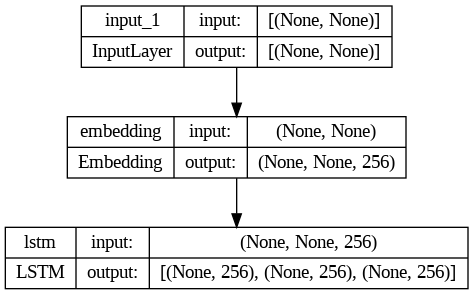

In [ ]:
from keras.utils import plot_model

plot_model(encoder_model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

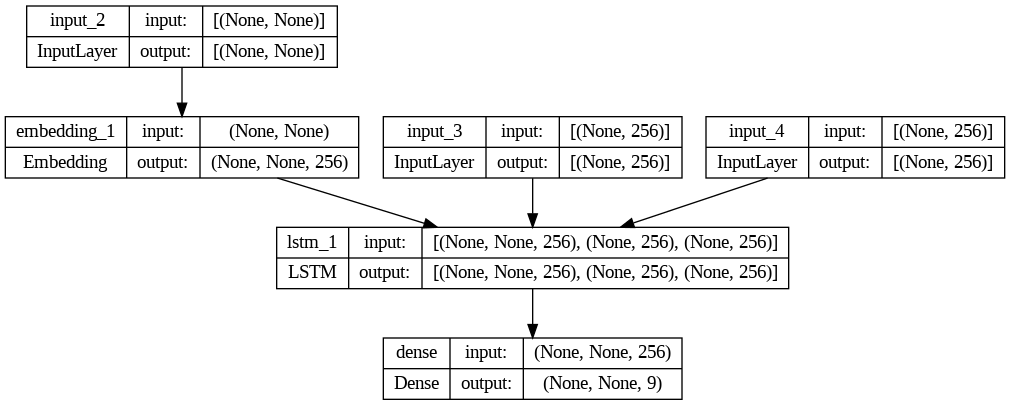

In [ ]:
plot_model(decoder_model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)